In [16]:
from ultralytics import YOLO
from pathlib import Path
from PIL import Image
import torch
import numpy as np
import cv2
import tensorflow as tf
import os
import keras_ocr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import networkx as nx
from itertools import combinations
import torch.nn as nn
import torch.optim as optim
import json
from transformers import pipeline
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, auc, average_precision_score, precision_recall_curve
import seaborn as sns
import ast

In [38]:
class HatefulMemesDatasetCombined(Dataset):
    def __init__(self, json_path, img_folder, transform=None):
        self.data = []
        with open(json_path, 'r') as f:
            for line in f:
                sample = json.loads(line)
                self.data.append(sample)

        self.img_folder = Path(img_folder)
        self.transform = transform
        self.sentiment_pipeline = pipeline("sentiment-analysis")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['img']
        img = Image.open(self.img_folder / img_path)

        label = torch.tensor(self.data[idx]['label'], dtype=torch.float32)
        text = self.data[idx]['text']
        
        sentiment_score = self.sentiment_pipeline(text)[0]['score']

        if self.transform:
            img = self.transform(img)

        return {'image': img, 'label': label, 'text': text, 'sentiment_score': sentiment_score}

transform = transforms.Compose([
    Lambda(lambda x: x.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = HatefulMemesDatasetCombined(json_path='./hateful_memes/train.jsonl', img_folder='./hateful_memes', transform=transform)
test_dataset = HatefulMemesDatasetCombined(json_path='./hateful_memes/test_unseen.jsonl', img_folder='./hateful_memes', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [39]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super(SentimentClassifier, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )

    def forward(self, sentiment_score):
        sentiment_score = sentiment_score.float()
        output = self.fc(sentiment_score)
        return output

input_size = 1  
model = SentimentClassifier(input_size=input_size, hidden_size=512)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2

In [40]:
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        sentiment_score = batch['sentiment_score']
        label = batch['label']

        output = model(sentiment_score.view(-1, 1))  # Reshape to (batch_size, 1)
        loss = criterion(output, label.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

Epoch 1/2: 100%|██████████| 266/266 [13:32<00:00,  3.05s/it]


Epoch [1/2], Loss: 0.6901987791061401


Epoch 2/2: 100%|██████████| 266/266 [12:27<00:00,  2.81s/it]

Epoch [2/2], Loss: 0.7292046546936035


In [41]:
model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []
    for batch in test_loader:
        sentiment_score = batch['sentiment_score']
        label = batch['label']

        output = model(sentiment_score.view(-1, 1))  # Reshape to (batch_size, 1)

        predicted = (output > 0.5).float()

        predictions.extend(predicted.squeeze().tolist())
        true_labels.extend(label.tolist())

accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 57.95%


# Trying for Improvements

In [29]:
class HatefulMemesDatasetCombined(Dataset):
    def __init__(self, json_path, img_folder, text_embeddings_path, image_embeddings_path, transform=None):
        self.data = []
        with open(json_path, 'r') as f:
            for line in f:
                sample = json.loads(line)
                self.data.append(sample)

        self.text_embeddings = pd.read_csv(text_embeddings_path)
        self.image_embeddings = pd.read_csv(image_embeddings_path)
        self.img_folder = Path(img_folder)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['img']
        img = Image.open(self.img_folder / img_path)

        label = torch.tensor(self.data[idx]['label'], dtype=torch.float32)
        text_id = int(self.data[idx]['id'])

        text_vectorized_text_str = self.text_embeddings.loc[self.text_embeddings['id'] == text_id, 'vectorized_text'].values[0]
        text_vectorized_text_list = [float(value) for value in text_vectorized_text_str[1:-1].split()]

        image_vectorized_text_str = self.image_embeddings.loc[self.image_embeddings['id'] == text_id, 'image_embeddings'].values[0]
        image_vectorized_text_list = [float(value) for value in image_vectorized_text_str[1:-1].split()]

        text_vectorized_text = torch.tensor(text_vectorized_text_list)
        image_vectorized_text = torch.tensor(image_vectorized_text_list)

        if self.transform:
            img = self.transform(img)

        return {'image': img, 'label': label, 'text_vectorized_text': text_vectorized_text, 'image_vectorized_text': image_vectorized_text}

class CombinedModel(nn.Module):
    def __init__(self, text_input_size, image_input_size, hidden_size=256):
        super(CombinedModel, self).__init__()
        self.lstm = nn.LSTM(text_input_size, hidden_size, batch_first=True)
        self.image_fc = nn.Sequential(
            nn.Linear(image_input_size, hidden_size),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, text_vectorized, image_vectorized):
        lstm_out, _ = self.lstm(text_vectorized.unsqueeze(1))  # Adding batch and sequence dimensions
        lstm_out = lstm_out[:, -1, :]
        image_features = self.image_fc(image_vectorized)
        combined_features = torch.cat((lstm_out, image_features), dim=1)
        output = self.fc(combined_features)
        return output

transform = transforms.Compose([
    Lambda(lambda x: x.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

text_embeddings_path = './Text-Embeddings.csv'
image_embeddings_path = './Image-Embedding.csv'

train_dataset = HatefulMemesDatasetCombined(json_path='./hateful_memes/train.jsonl', img_folder='./hateful_memes', text_embeddings_path=text_embeddings_path, image_embeddings_path=image_embeddings_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

text_input_size = len(train_dataset[0]['text_vectorized_text'])
image_input_size = len(train_dataset[0]['image_vectorized_text'])
model = CombinedModel(text_input_size=text_input_size, image_input_size=image_input_size, hidden_size=256)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        text_vectorized_text = batch['text_vectorized_text']
        image_vectorized_text = batch['image_vectorized_text']
        label = batch['label']

        output = model(text_vectorized_text, image_vectorized_text)
        loss = criterion(output, label.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

Epoch 1/10: 100%|██████████| 266/266 [02:38<00:00,  1.68it/s]


Epoch [1/10], Loss: 0.5159925222396851


Epoch 2/10: 100%|██████████| 266/266 [02:36<00:00,  1.70it/s]


Epoch [2/10], Loss: 0.7161892056465149


Epoch 3/10: 100%|██████████| 266/266 [02:35<00:00,  1.72it/s]


Epoch [3/10], Loss: 0.41970300674438477


Epoch 4/10: 100%|██████████| 266/266 [02:34<00:00,  1.72it/s]


Epoch [4/10], Loss: 0.5791805386543274


Epoch 5/10: 100%|██████████| 266/266 [02:35<00:00,  1.71it/s]


Epoch [5/10], Loss: 0.7007245421409607


Epoch 6/10: 100%|██████████| 266/266 [02:34<00:00,  1.72it/s]


Epoch [6/10], Loss: 0.5981111526489258


Epoch 7/10: 100%|██████████| 266/266 [02:38<00:00,  1.68it/s]


Epoch [7/10], Loss: 0.5328210592269897


Epoch 8/10: 100%|██████████| 266/266 [03:18<00:00,  1.34it/s]


Epoch [8/10], Loss: 0.4269869923591614


Epoch 9/10: 100%|██████████| 266/266 [03:04<00:00,  1.44it/s]


Epoch [9/10], Loss: 0.5294850468635559


Epoch 10/10: 100%|██████████| 266/266 [04:10<00:00,  1.06it/s]

Epoch [10/10], Loss: 0.5241050124168396


Evaluating: 100%|██████████| 32/32 [00:34<00:00,  1.08s/it]


Test Accuracy: 60.50%
F1 Score:  0.5811240721102864
              precision    recall  f1-score   support

         0.0       0.61      0.65      0.63       510
         1.0       0.60      0.56      0.58       490

    accuracy                           0.60      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.60      0.60      0.60      1000



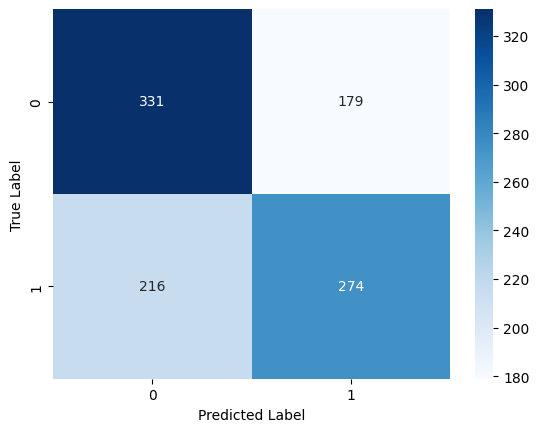

In [36]:
image_embeddings_path_test = './Image-Embedding-Test.csv'
text_embeddings_path_test = './Text-Embeddings_test.csv'

test_dataset = HatefulMemesDatasetCombined(json_path='./hateful_memes/test_seen.jsonl', img_folder='./hateful_memes', text_embeddings_path=text_embeddings_path_test, image_embeddings_path=image_embeddings_path_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        text_vectorized_text = batch['text_vectorized_text']
        image_vectorized_text = batch['image_vectorized_text']
        label = batch['label']

        output = model(text_vectorized_text, image_vectorized_text)

        predicted = (output > 0.5).float()

        predictions.extend(predicted.squeeze().tolist())
        true_labels.extend(label.tolist())

accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

print("F1 Score: ", f1_score(true_labels, predictions))

print(classification_report(true_labels, predictions))

cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

ROC-AUC Score: 0.6041016406562626


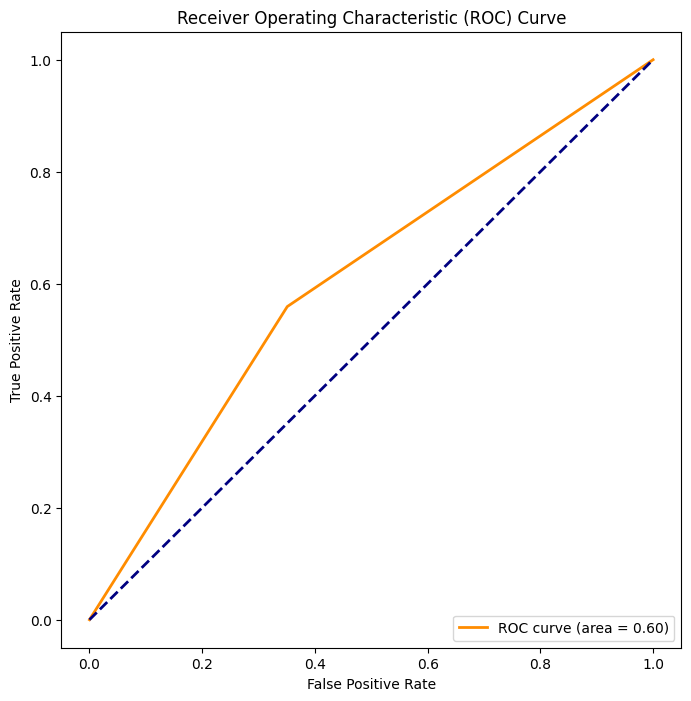

In [34]:
roc_auc = roc_auc_score(true_labels, predictions)
print(f'ROC-AUC Score: {roc_auc}')

fpr, tpr, _ = roc_curve(true_labels, predictions)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()